In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import glob
import re
import datetime

import matplotlib as mpl

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cartopy as cart
import scipy.stats as stats
import random


from CE_Functions import *
from ClimateModesForCEs import *
from PlottingForCEs import *

mpl.rcParams['figure.dpi'] = 300

In [3]:
## CALL IN FILES ## 
cesm_trefht_dir = "../CESM_data/TREFHT/2mtemptaketwo/"
cesm_trefht_files = sorted(glob.glob(f"{cesm_trefht_dir}*.nc"))

cesm_prect_dir = "../CESM_data/PRECT/prect_data_take_two/"
cesm_prect_files = sorted(glob.glob(f"{cesm_prect_dir}*.nc"))


cesm_ts_dir = "../CESM_data/TS/ts_data2/"
cesm_ts_files = sorted(glob.glob(f"{cesm_ts_dir}*.nc"))


## SORT FILENAMES ##

# Function to extract the numerical value from the filename
def extract_number(filename):
    match = re.search(r'\d{3,4}\.\d{3}', filename)
    if match:
        return tuple(map(int, match.group().split('.')))
    return (0, 0)  # Default value if no match found

# Sort filenames based on the extracted numerical value
sorted_filenames_trefht = sorted(cesm_trefht_files, key = extract_number)
sorted_filesnames_prect = sorted(cesm_prect_files, key = extract_number)
sorted_filenames_ts = sorted(cesm_ts_files, key = extract_number)

trefht_avg_past, prect_avg_past, ts_avg_all = ensemble_mean(cesm_trefht_files, cesm_prect_files, cesm_ts_files, 0, 3012)


In [ ]:
trefht_data = []
for file in cesm_trefht_files:
    open_file = xr.load_dataset(file)["TREFHT"] - 273.15
    var_timespan = np.std(open_file, axis = 0)
    trefht_data.append(var_timespan)



prect_data = []
for file in cesm_prect_files:
    open_file = xr.load_dataset(file)["PRECT"]
    var_timespan = np.std(open_file, axis = 0)
    prect_data.append(var_timespan)



In [ ]:
lat = trefht_data[0]['lat']
lon = trefht_data[0]['lon']
average_std = xr.DataArray(np.mean(trefht_data, axis = 0), coords = {'lat': lat, 'lon': lon}, dims = ['lat', 'lon'])

In [ ]:
lat_threshold = -57

mask = trefht_data[0]['lat'] >= lat_threshold
masked_lat = trefht_data[0]['lat'][mask]
masked_data = average_std.isel(lat = mask)

plt.figure(figsize=(12,6))
ax = plt.axes(projection = ccrs.PlateCarree()) 
plt.pcolormesh(masked_data['lon'], masked_lat, masked_data, cmap = 'Reds', transform = ccrs.PlateCarree(), vmin = 0, vmax = 20)
plt.colorbar(label = 'Average Standard Deviation', orientation = 'horizontal', extend = 'max', fraction = 0.05, pad = 0.01)
ax.coastlines()
ax.add_feature(cart.feature.OCEAN, zorder = 100, edgecolor='k', color = 'white')
ax.add_feature(cfeature.COASTLINE, zorder=101, edgecolor='black')
plt.title('Standard Deviation 1850-2100 (CESM2-LE Ensemble Average)')

Attempt at the timeseries, but had memory issue so this is moved to ASHA

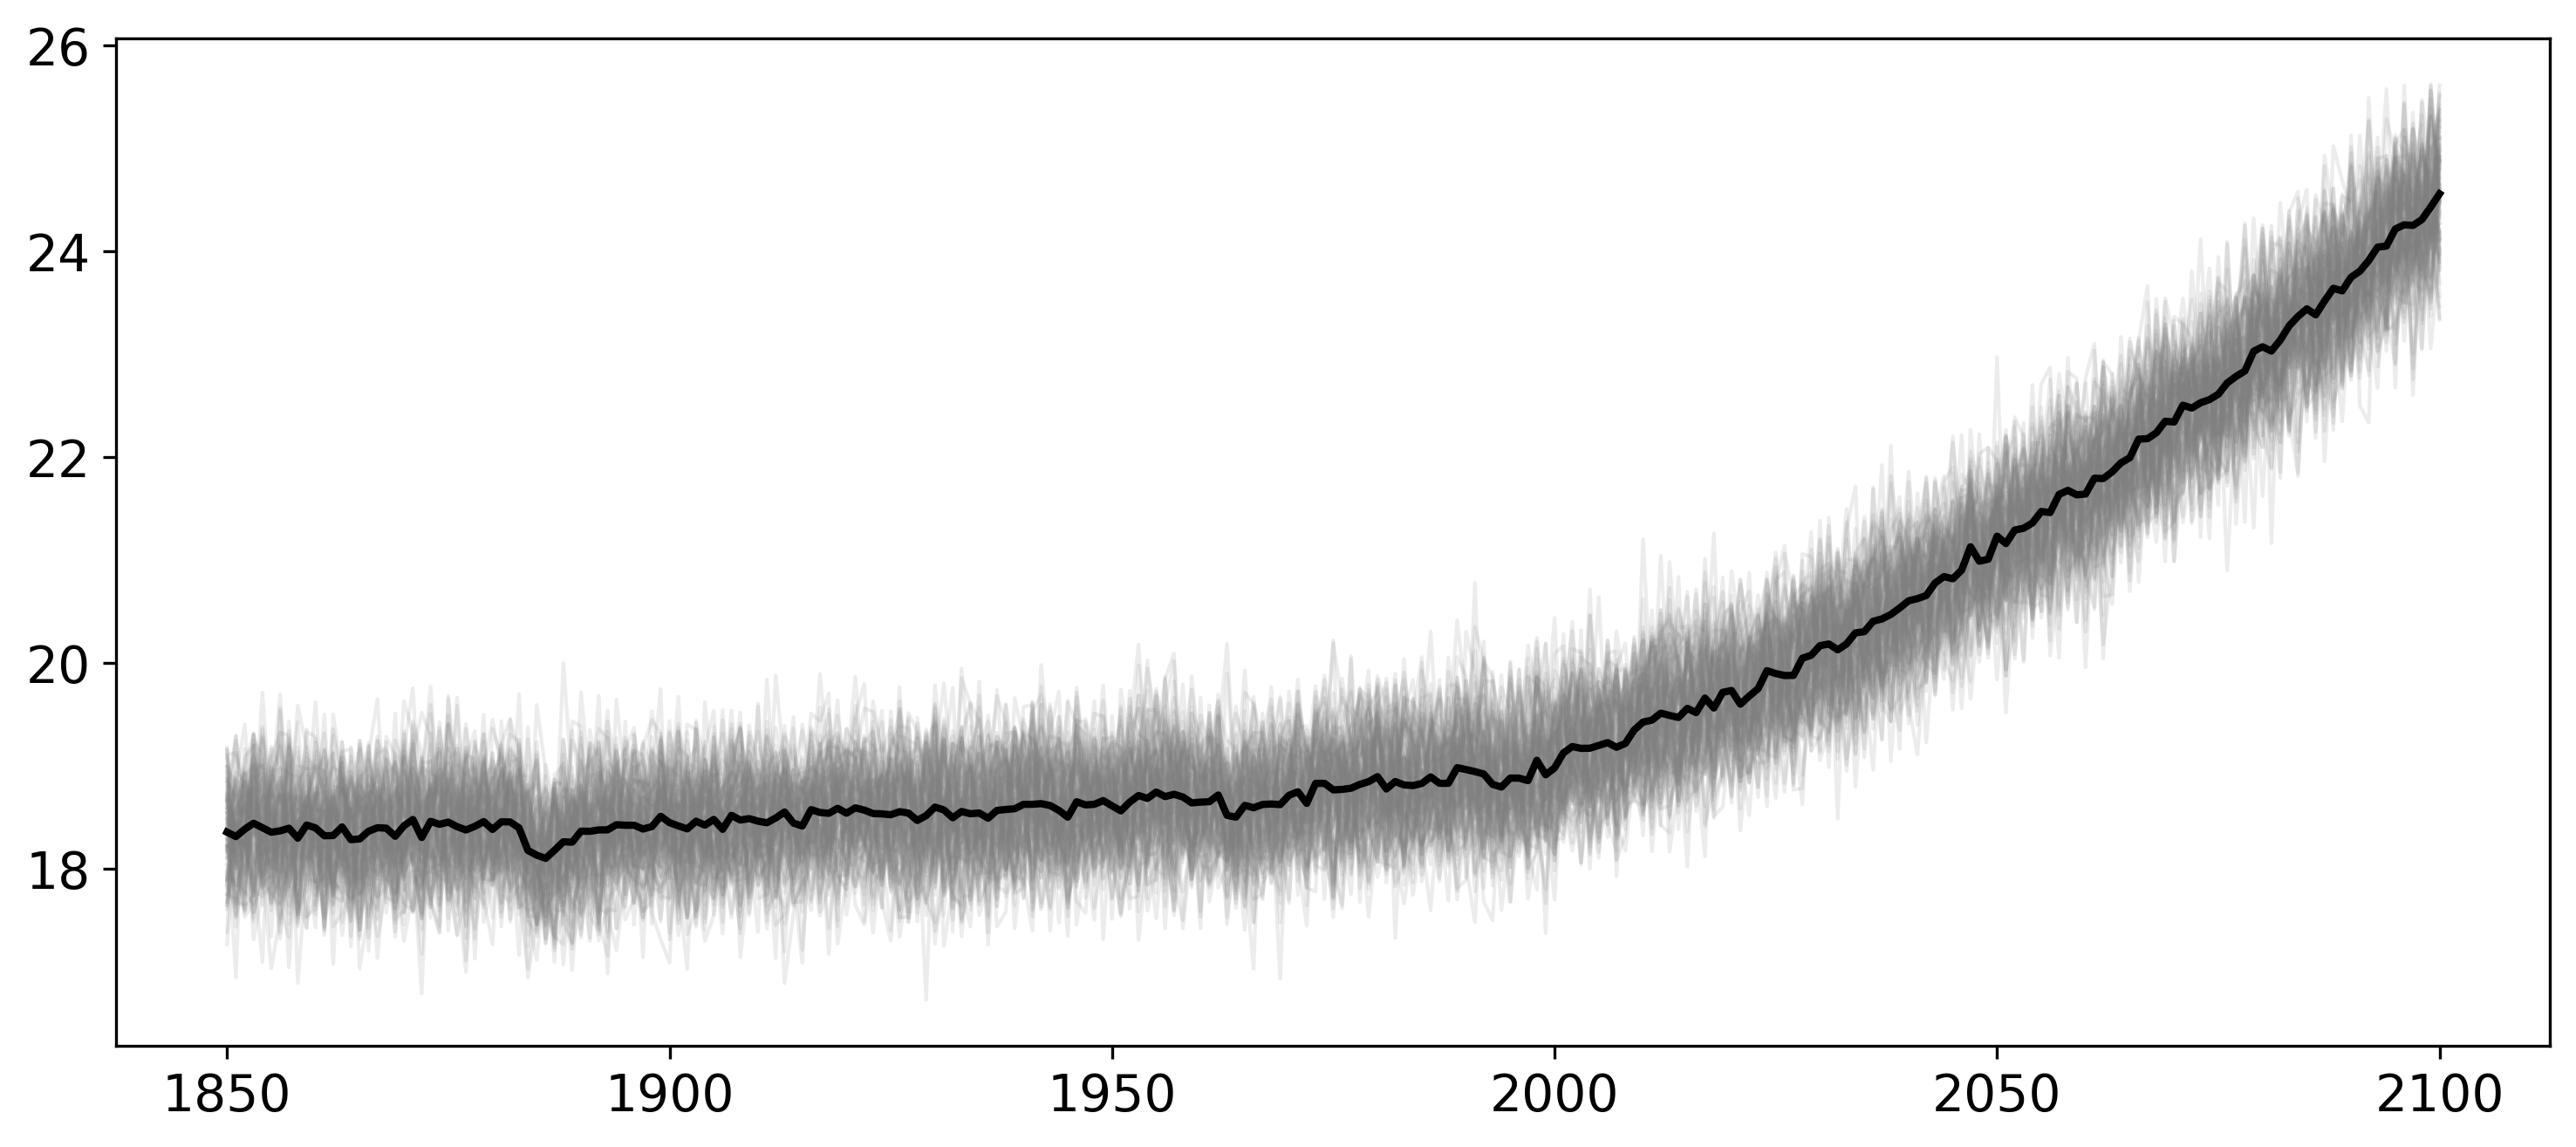

In [7]:
lat_c = -30.63
lon_c = 118.50

trefht_data = []
plt.figure(figsize=(12,5))
for file in cesm_trefht_files:
    open_file = xr.load_dataset(file)["TREFHT"] - 273.15
    trefht_resampled = open_file.sel(lat = lat_c, lon = lon_c, method = 'nearest').resample(time = 'YE').mean()
    trefht_data.append(trefht_resampled)
    plt.plot(np.arange(1850, 2101, 1), trefht_resampled, alpha = 0.15, color = 'gray', linewidth = 1)

trefht_data_np = np.array(trefht_data)
average_temp = np.mean(trefht_data_np, axis = 0)
plt.plot(np.arange(1850, 2101, 1), average_temp, alpha = 1, color = 'black', linewidth = 2)


#plt.title('f) Temperature Timeseries for Southwest Australia', size = 22)
#plt.ylabel('Temperature (°C)', size = 20)
#plt.xlabel('Time', size = 20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
hold = []
for i in trefht_data:
    hold.append(i[:50])
print(hold)
hold_np = np.array(hold)
average_temp = np.mean(hold_np)
average_temp
np.quantile(hold, 0.90)

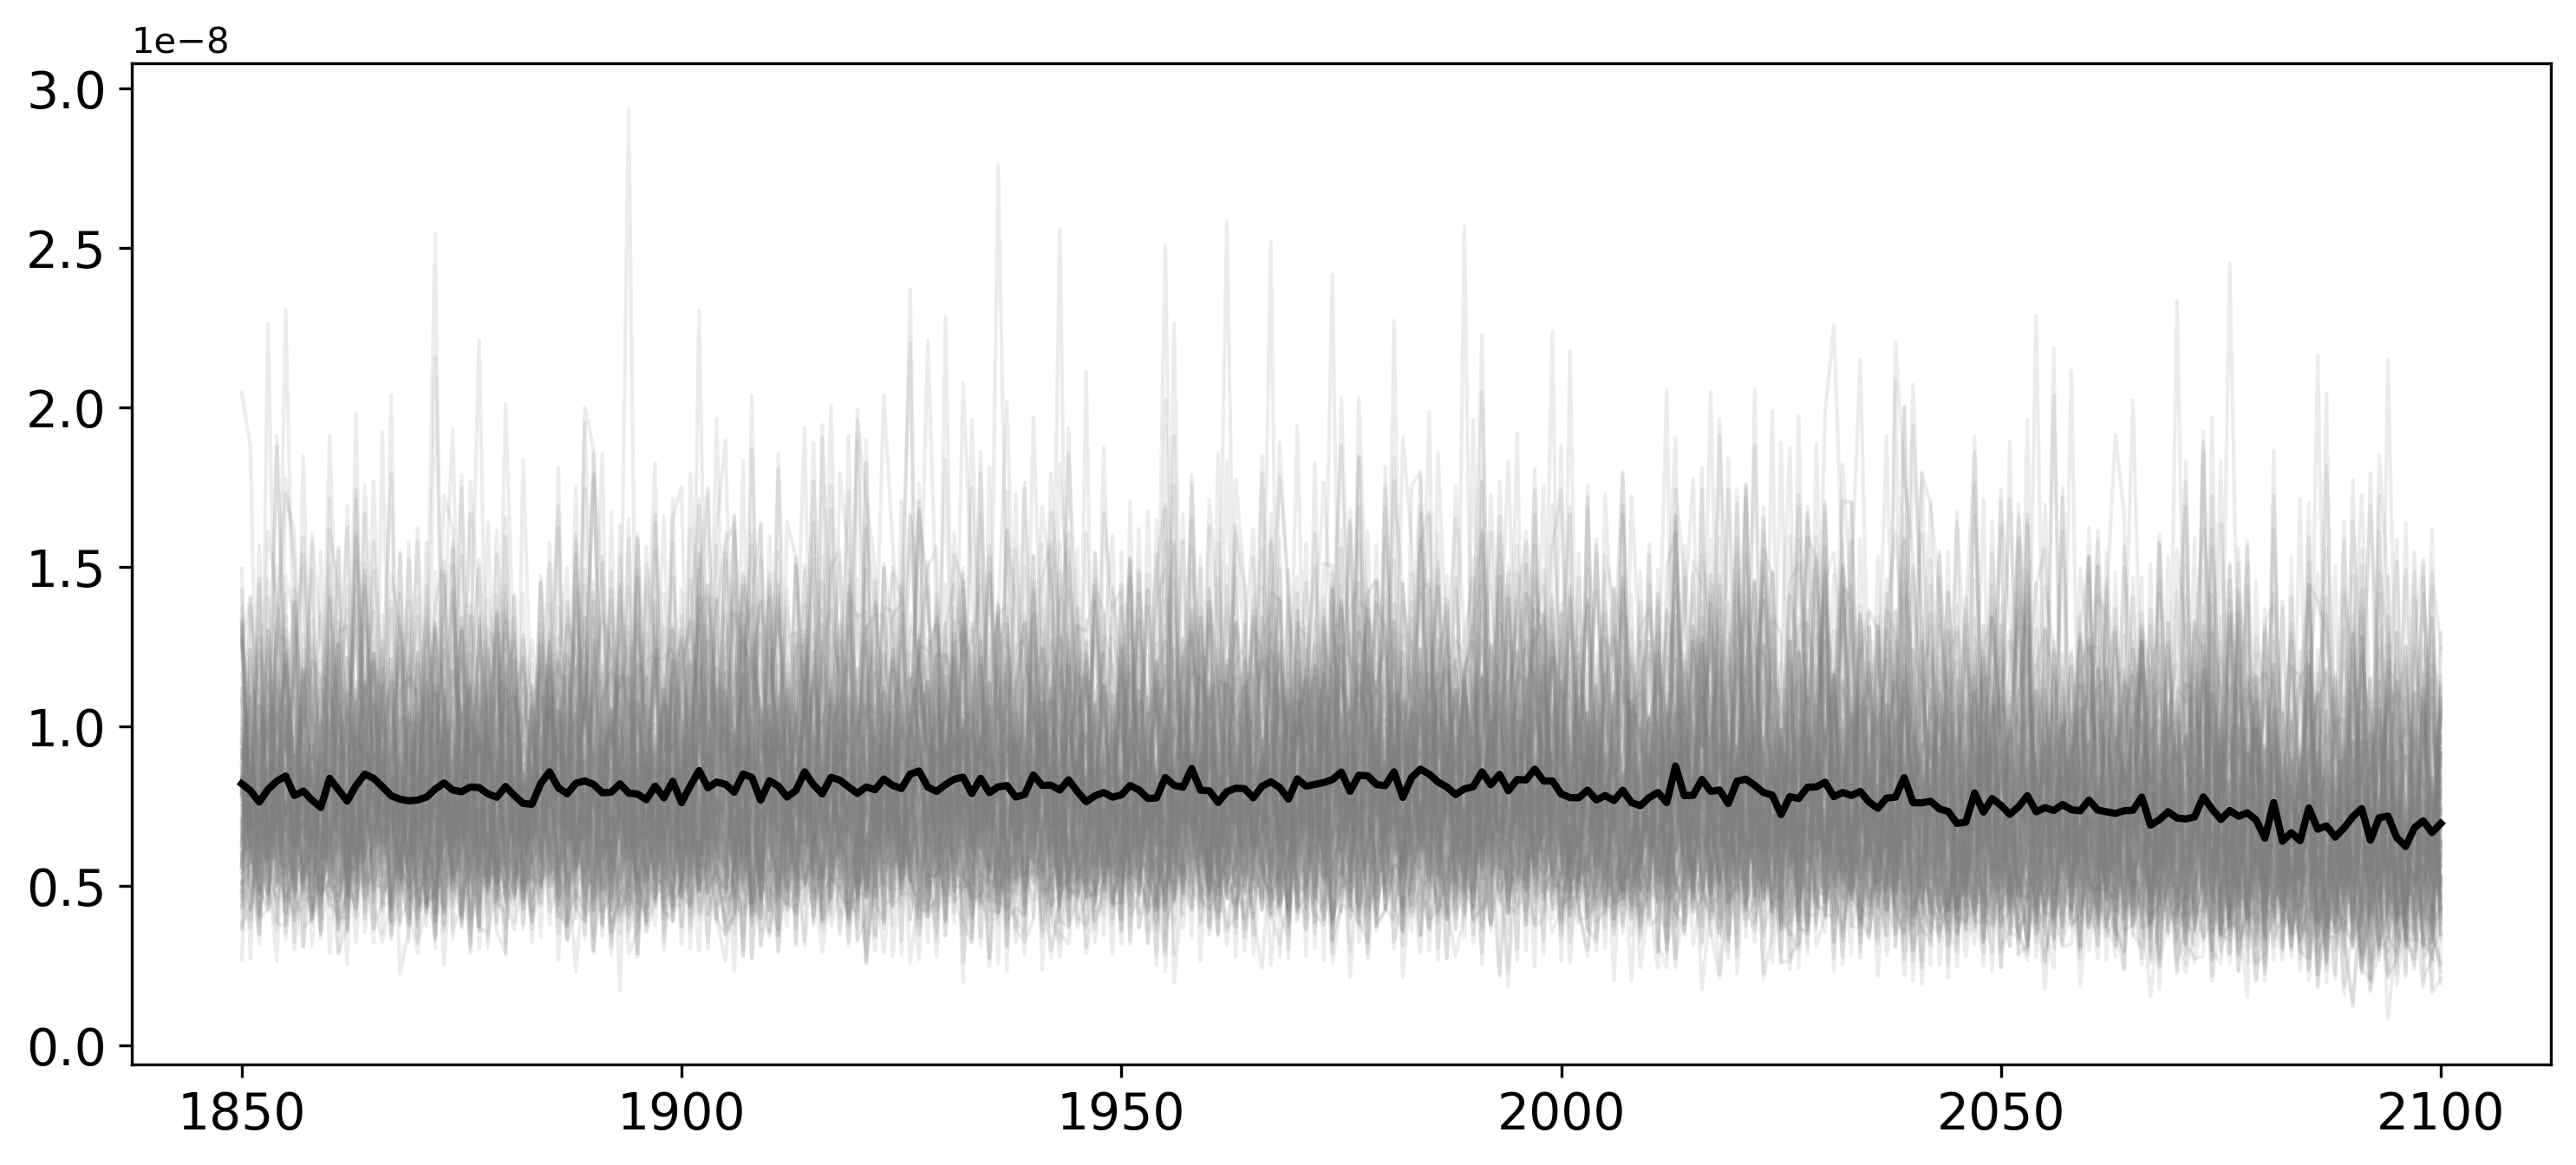

In [8]:
lat_c = -30.63
lon_c = 118.50
r_squared_bool = False

years = np.arange(1850,2101,1)
prect_data = []
plt.figure(figsize=(12,5))
for file in cesm_prect_files:
    open_file = xr.load_dataset(file)["PRECT"]
    prect_resampled = open_file.sel(lat = lat_c, lon = lon_c, method = 'nearest').resample(time = 'YE').mean()
    prect_data.append(prect_resampled)
    plt.plot(years, prect_resampled, alpha = 0.15, color = 'gray', linewidth = 1)

prect_data_np = np.array(prect_data)
average_prect = np.mean(prect_data_np, axis = 0)
plt.plot(years, average_prect, alpha = 1, color = 'black', linewidth = 2)

# Compute the linear trend
slope_future, intercept_future = np.polyfit(years[150:], average_prect[150:], 1)
trend_line_future = slope_future * years[150:] + intercept_future

# Compute the linear trend
slope_past, intercept_past = np.polyfit(years[:101], average_prect[:101], 1)
trend_line_past = slope_past * years[:101] + intercept_past

# Compute R^2
if r_squared_bool:
    y_pred = trend_line  # Predicted values from the regression
    y_actual = average_prect[150:]  # Actual precipitation values

    SS_total = np.sum((y_actual - np.mean(y_actual))**2)
    SS_residual = np.sum((y_actual - y_pred)**2)
    r_squared = 1 - (SS_residual / SS_total)

# Plot the trend line
#plt.plot(years[150:], trend_line_future, color='red', linestyle='dashed', linewidth=4) #, label=r_squared)
#plt.plot(years[:101], trend_line_past, color = 'blue', linestyle='dashed', linewidth=4)



#plt.title('e) Precipitation Timeseries for Southern South Sudan', size = 22)
#plt.ylabel('Precipitation Rate (m/s)', size = 20)
#plt.xlabel('Time', size = 20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.legend()
plt.show()

In [ ]:
hold = []
for i in prect_data:
    hold.append(i[:50])
print(hold)
hold_np = np.array(hold)
average_prect = np.mean(hold_np)
average_prect
#np.quantile(hold, 0.10)

changes in climate modes over time.

In [ ]:
cdvp_dir = '/Users/aedwyer/Documents/CESM_data/cesm2-lens_1850-2100.cvdp_data/CDVP_Members/'
cdvp_files = sorted(glob.glob(cdvp_dir + '/*.nc'))

In [ ]:
# detrend the climate drivers
def detrend_modes(mode_files, variable):
    mode_sum = 0
    for file in mode_files:
        mode_ds = xr.open_dataset(file, decode_times = False)
        mode_vals = mode_ds[variable]
        mode_sum += mode_vals
        mode_ds.close()
    mode_avg = mode_sum / 100
    return mode_avg
nino34_average = detrend_modes(cdvp_files, 'nino34')
pdo_average = detrend_modes(cdvp_files, 'pdv_prime_timeseries_mon')
iod_average = detrend_modes(cdvp_files, 'indian_ocean_dipole')

In [ ]:
cesm_SLP_dir = "/Users/aedwyer/Documents/CESM_data/SLP/SLP_monthly_data/"
cesm_slp_files = sorted(glob.glob(f"{cesm_SLP_dir}*.nc"))

# Function to extract the numerical value from the filename
def extract_number(filename):
    match = re.search(r'\d{3,4}\.\d{3}', filename)
    if match:
        return tuple(map(int, match.group().split('.')))
    return (0, 0)  # Default value if no match found

# Sort filenames based on the extracted numerical value
sorted_filenames_slp = sorted(cesm_slp_files, key = extract_number)

slp_sum = 0
for i, file in enumerate(cesm_slp_files):
    slp_ds = xr.open_dataset(file)
    slp_var = slp_ds['PSL']
    slp_sum += slp_var
    slp_ds.close()

slp_avg = (slp_sum / 100)

NAO_indices_per_member = []
for slp_file in sorted_filenames_slp:
    ds = xr.open_dataset(slp_file)
    # Get anomalies from the ensemble mean, this is now the data
    X = ds['PSL'] - slp_avg
    # take the mean of the individual member's anomalies to get the mean needed for normalization
    mem_mean = np.mean(X, axis = 0)
    # take the std dev of the individual member
    std_dev = X.std(dim = 'time')
    # calculate normalized values for the specific member
    normalized_anoms = (X - mem_mean) / std_dev
    icelandic_low_pressures = normalized_anoms.sel(lat = 64, lon = 360 - 22, method = 'nearest')
    azores_high_pressures = normalized_anoms.sel(lat = 37.75, lon = 360 - 25.6, method = 'nearest')
    # Take the difference between the two stations for the index
    NAO_index = azores_high_pressures - icelandic_low_pressures
    NAO_indices_per_member.append(NAO_index)

In [ ]:
cdvp_files[6]

In [ ]:
want_fig = True
var_1850 = []
var_2000 = []
for mem in cdvp_files[:3]:
    mode_mem = xr.load_dataset(mem, decode_times = False)['nino34']
    mode_detrended = mode_mem - nino34_average

    var_1850.append((np.var(mode_detrended[0:1212])).values)
    var_2000.append((np.var(mode_detrended[1800:])).values)

    # Fit linear model (y = mx + b)
    m1, b1 = np.polyfit(mode_detrended['time'][:1212], mode_detrended[:1212], 1)

    # Generate trend line
    y_pred_1850 = m1 * mode_detrended['time'][:1212] + b1

    # Fit linear model (y = mx + b)
    m2, b2 = np.polyfit(mode_detrended['time'][1800:], mode_detrended[1800:], 1)

    # Generate trend line
    y_pred_2000 = m2 * mode_detrended['time'][1800:] + b2
    
    if want_fig:
        # Generate a date range from 1850 to 2100 with monthly frequency
        dates = pd.date_range(start="1850-01", end="2100-12", freq="MS")

        plt.figure(figsize=(12,8))
        plt.plot(dates[:1212], mode_detrended[:1212], color = 'purple', label = f" variance = {np.round((np.var(mode_detrended[0:1212])).values,2)}", linewidth = 2)
        plt.plot(dates[1212:1800], mode_detrended[1212:1800], color = 'gray')
        plt.plot(dates[1800:], mode_detrended[1800:], color = 'green', label = f"variance = {np.round((np.var(mode_detrended[1800:])).values,2)}", linewidth = 2)
        #plt.plot(dates[:1212], y_pred_1850, color='red')
        #plt.plot(dates[1800:], y_pred_2000, color='red')
        plt.ylabel('ENSO Indices')
        plt.title(f'ENSO Indices after removing ensemble mean, member 1001.001')
        plt.legend()

NAO Timeseries

In [ ]:
sorted_filenames_slp[2]

In [ ]:
want_fig = True
var_1850 = []
var_2000 = []
for mem in NAO_indices_per_member[1:3]:
    mode_detrended = mem

    var_1850.append((np.var(mode_detrended[0:1212])).values)
    var_2000.append((np.var(mode_detrended[1800:])).values)
    
    if want_fig:
        # Generate a date range from 1850 to 2100 with monthly frequency
        dates = pd.date_range(start="1850-01", end="2100-12", freq="MS")

        plt.figure(figsize=(12,8))
        plt.plot(dates[:1212], mode_detrended[:1212], color = 'purple', label = f" variance = {np.round((np.var(mode_detrended[0:1212])).values,2)}", linewidth = 2)
        plt.plot(dates[1212:1800], mode_detrended[1212:1800], color = 'gray')
        plt.plot(dates[1800:], mode_detrended[1800:], color = 'green', label = f"variance = {np.round((np.var(mode_detrended[1800:])).values,2)}", linewidth = 2)
        #plt.plot(dates[:1212], y_pred_1850, color='red')
        #plt.plot(dates[1800:], y_pred_2000, color='red')
        plt.ylabel('NAO Indices')
        plt.title(f'NAO Indices after removing ensemble mean, member 1021.002')
        plt.legend()

In [ ]:
print(np.mean(np.array(var_1850)))
np.mean(np.array(var_2000))

In [ ]:
def surface_temperature_composite(NAO_data, cdvp_mems, var_mems, var_avg, mode_avg, pos_mode = True, mode_name = '', var_name = '', NAO = False):
    import xarray as xr
    # Create list to hold all the true indices for compound events for one location
    true_indices_list = []

    # loop through all the members for the CE indices
    for mode_file, mem in enumerate(cdvp_mems):
        mode_mem = xr.load_dataset(mem, decode_times = False)[mode_name]
        mode_detrended = mode_mem - mode_avg
        if NAO:
            mode_detrended = NAO_data[mode_file]
        # pull out the true indicies 
        if pos_mode:
            true_indices = [index for index, value in enumerate(mode_detrended) if value >= 0.5]
        else:
            true_indices = [index for index, value in enumerate(mode_detrended) if value <= -0.5]
        # append the true indices to a list to call later
        true_indices_list.append(true_indices)


    # temperature sum to average for the composite map
    temp_sum = 0
    # true indicies index to loop through the members from the true indices list
    true_indicies_i = 0
    # test to compare to the true indices sum earlier
    test_i = 0

    for file in var_mems:
        # call the surface temperature file and values and convert to celsius
        var_anom_clim = xr.open_dataset(file)[var_name] - 273.15
        var_anom_clim = var_anom_clim - var_avg
        # call the true indicies for that specific member
        temp_list = true_indices_list[true_indicies_i]
        
        # loop through all the true indices for that member
        for i in temp_list:
            #if i == 0:
            #   print(i)
            #   next
            # add the temperature from whatever month you want around the index for the compound event to the sum
            temp_sum += var_anom_clim[i] # -1 for the month before
            test_i += 1
        true_indicies_i += 1
    composite_map_temperature = temp_sum / test_i
    return composite_map_temperature, var_anom_clim

In [ ]:
composite_map_temp, ts_anom_clim  = surface_temperature_composite(NAO_indices_per_member, cdvp_files, sorted_filenames_ts, ts_avg_all, iod_average, False, 'indian_ocean_dipole', 'TS', True)

In [ ]:
## PLOT ##
lon = ts_anom_clim['lon']
lat = ts_anom_clim['lat']

plt.figure(figsize=(14,6))
ax = plt.axes(projection = ccrs.EqualEarth())
plt.pcolormesh(lon, lat, composite_map_temp, transform = ccrs.PlateCarree(), cmap = 'coolwarm', vmin = -1, vmax = 1) #, vmin = -4e-9, vmax = 4e-9)
#cbar = plt.colorbar(extend = 'both', orientation = 'horizontal', fraction = 0.05, pad = 0.01)
#cbar.set_label('Precipitation Rate Anomaly', size = 12)
ax.coastlines()
plt.title(f"h) Temperature Anomalies under Negative NAO", size = 22)
ax.add_feature(cart.feature.OCEAN, zorder = 100, edgecolor='k', color = 'gray')
ax.add_feature(cfeature.COASTLINE, zorder=101, edgecolor='black')
plt.show()

CLIMATE CHANGE PLOTS

In [ ]:
cc_ces = xr.open_dataset('/Users/aedwyer/Documents/CESM_data/QuantilesPerMonth_90T_10P_1850_2100_w1850_1900_PooledQuant.nc')

In [ ]:
## FOR TEMPERATURE ANOMALIES ##
plt.figure(figsize=(16,8))
dates = pd.date_range(start="1850-01-01", end="2101-01-01", freq="ME")
trefht_anom_clim = xr.load_dataset(cesm_trefht_files[0])["TREFHT"] - 273.15

#quant_ex = np.quantile(trefht_anom_clim[:50].sel(lat =40.58, lon = 360 - 105.08, method = 'nearest'), 0.90)



#plt.plot(dates, trefht_anom_clim[:1212].sel(lat = -2.85, lon = 360 - 52.52, method = 'nearest'), color = 'gray')
#plt.plot(dates, trefht_avg_past.sel(lat = -2.85, lon = 360 - 52.52, method = 'nearest'), color = 'green', linewidth = 1)
plt.plot(dates, (trefht_anom_clim).sel(lat =40.58, lon = 360 - 105.08, method = 'nearest'), color = 'black', linewidth = 1)
#plt.axhline(quant_ex, color = 'black', linewidth = 3)
#plt.axhspan(quant_ex, max(range(len(dates))), facecolor="red", alpha=0.3, label="Above Threshold")
#plt.ylim(-7,7)
plt.title('Temperature, Fort Collins, CO', size = 24)
plt.ylabel('Temperature (°C)', size = 20)
plt.show()

In [ ]:
## FOR PRECIP ANOMALIES
plt.figure(figsize=(16,8))
prect_anom_clim = xr.load_dataset(cesm_prect_files[0])["PRECT"]

#quantp_ex = np.quantile(prect_anom_clim.sel(lat =40.58, lon = 360 - 105.08, method = 'nearest'), 0.10)
plt.plot(dates, (prect_anom_clim).sel(lat =40.58, lon = 360 - 105.08, method = 'nearest'), color = 'black', linewidth = 1)
#plt.axhline(quantp_ex, color = 'black', linewidth = 3)
#plt.axhspan(min(prect_anom_clim.sel(lat =40.58, lon = 360 - 105.08, method = 'nearest').values), quantp_ex, facecolor="brown", alpha=0.3, label="Below Threshold")
plt.title('Precipitation, Fort Collins, CO', size = 24)
#plt.ylim(-4e-8,4e-8)
plt.ylabel("Precipitation Rate", size = 20)
plt.show()

In [ ]:
## PLOT ##
lon = ts_anom_clim['lon']
lat = ts_anom_clim['lat']

plt.figure(figsize=(14,6))
ax = plt.axes(projection = ccrs.EqualEarth())
plt.pcolormesh(lon, lat, composite_map_temp, transform = ccrs.PlateCarree(), cmap = 'coolwarm', vmin = -1, vmax = 1) #, vmin = -4e-9, vmax = 4e-9)
#cbar = plt.colorbar(extend = 'both', orientation = 'horizontal', fraction = 0.05, pad = 0.01)
#cbar.set_label('Precipitation Rate Anomaly', size = 12)
ax.coastlines()
#plt.title(f"h) Temperature Anomalies under Negative NAO", size = 22)
ax.add_feature(cart.feature.OCEAN, zorder = 100, edgecolor='k', color = 'white')
ax.add_feature(cart.feature.LAND, zorder = 100, edgecolor = 'k', color = 'gray')
#ax.add_feature(cart.feature.LAKES, zorder = 101, edgecolor = 'k', color = 'white')
ax.add_feature(cfeature.COASTLINE, zorder=101, edgecolor='black')
plt.show()